<b>Author : Aneesh Sathe<b>

# ConvLSTM for Engineering Building A 

Hyper-parameters - 
Epoch: 1500
Conv Channels : 64
Kernel : 3
LSTM Layers : 32
LR: 0.001

In-Steps: 7
Out-Steps: 1

In [1]:
'''Importing Required Libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob                          
import warnings  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch     
from torch import nn
from torchinfo import summary
warnings.filterwarnings('ignore')

## setting manual seed to avoid random initialisation of weights

In [2]:
torch.manual_seed(42) 

In [3]:
torch.rand(3,4)

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])

## data preprocessing

In [4]:
'''Loading the Data from File Directory'''
data = sorted(glob.glob('building_A/2022-10-*.csv'))

In [5]:
def make_data(data):
    month_dfs = []
    '''Read from File, Convert to Dataframe and Concatanate'''
    for _ in data:
        df = pd.read_csv(_, usecols = ['UpdateTime','Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Freq', 'PF'], index_col = False)
        df = df[['UpdateTime', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'PF', 'Freq' ]]
        df['UpdateTime'] = pd.to_datetime(df['UpdateTime'])
        month_dfs.append(df)
    month_df = pd.concat(month_dfs)
    '''Re-Sample the Data + Reduce Datapoints to Every Minute Interval'''
    resampled_data = month_df.set_index('UpdateTime')
    resampled_data = resampled_data.resample('1T').mean().interpolate(method='linear')
    resampled_data.reset_index(inplace=True)
    X, y = resampled_data.drop(columns = ['UpdateTime']), resampled_data.Freq.values
    return X, y
        

In [6]:
'''Preparing Data into Sequence for LSTM'''
def create_seq(X, y, seq_length):
    sequences_X = []
    sequences_y = []

    for i in range(len(X) - seq_length):
        sequences_X.append(X[i:i+seq_length])
        sequences_y.append(y[i+seq_length])

    seq_X = np.array(sequences_X)
    seq_y = np.array(sequences_y)
    return seq_X, seq_y

In [7]:
def scale_data(X, y):
    mm = MinMaxScaler()
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    y_scaled = mm.fit_transform(y.reshape(-1,1))
    return X_scaled, y_scaled, mm
    

In [8]:
'''Converting Data into Torch Tensor for PyTorch Model'''
def make_tensor(X_train, X_test, y_train, y_test):
    X_train = torch.tensor(X_train, requires_grad = True)
    X_test = torch.tensor(X_test, requires_grad = True)
    y_train = torch.tensor(y_train, requires_grad = True)
    y_test = torch.tensor(y_test, requires_grad = True)
    return X_train, X_test, y_train, y_test

In [9]:
X, y = make_data(data) # Preparing Data for Building A
X_scaled, y_scaled, mm = scale_data(X, y)

''' Predicting the Next  Time Step from Previous 7 Time Steps'''

in_step = 7
X_ss, y_mm = create_seq(X_scaled, y_scaled, in_step) #split into data format for lstm training
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size = 0.3, shuffle = False)
X_train, X_test, y_train, y_test= make_tensor(X_train, X_test, y_train, y_test)


In [10]:
X_train.shape

torch.Size([29658, 7, 8])

## creating & training the model

In [11]:
class ConvLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 7, out_channels = 64, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)
        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out 
        

In [19]:
def training_loop(epochs, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test):
    #X_train, y_train, X_test, y_test = X_train.double(), y_train.double(), X_test.double(), y_test.double()
    mse_train_count, mse_test_count = list(), list()
    mae_train_count, mae_test_count = list(), list()
    min_loss = 100
    for _ in range(epochs):
        conv_lstm.train()
        out = conv_lstm.forward(X_train.float())
        optimiser.zero_grad()
        mse_loss = loss1(out, y_train.float())
        mae_loss = loss2(out, y_train.float())
        mse_loss.backward()
        optimiser.step()
        conv_lstm.eval()
        with torch.inference_mode():
            test_pred = conv_lstm.forward(X_test.float())
            mse_test_loss = loss1(test_pred, y_test.float())
            mae_test_loss = loss2(test_pred, y_test.float())
            if _ % 100 == 0:
                if mse_test_loss.item() < min_loss :
                    min_loss = mse_test_loss.item()
                    torch.save(conv_lstm.state_dict(), 'saved_models_update/convLSTM-A.pth')
                print(f" Epoch : {_} | MSE Train Loss : {mse_loss.item()} | MSE Test Loss : {mse_test_loss.item()} | MAE Train Loss : {mae_loss.item()} | MAE Test Loss : {mae_test_loss.item()}")
                mse_train_count.append(mse_loss.item())
                mse_test_count.append(mse_test_loss.item())   
                mae_train_count.append(mae_loss.item())
                mae_test_count.append(mae_test_loss.item()) 
    '''Plotting Train - Test Loss Graphs'''
    
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,100), mse_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,100), mse_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_A - MSE Loss')
    
    plt.show()
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,100), mae_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,100), mae_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_A - MAE Loss')
    plt.show()

In [20]:
input_size = 8 # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 1 # number of output classes 
conv_lstm = ConvLSTM(num_classes, input_size, hidden_size, num_layers)
loss1 = torch.nn.MSELoss().double()
loss2 = torch.nn.L1Loss().double()
optimiser = torch.optim.Adam(conv_lstm.parameters(), lr = 0.0001)

In [21]:
summary(conv_lstm, input_size = (29658, 7, 8))

Layer (type:depth-idx)                   Output Shape              Param #
ConvLSTM                                 [29658, 1]                --
├─Conv1d: 1-1                            [29658, 64, 8]            1,408
├─ReLU: 1-2                              [29658, 64, 8]            --
├─LSTM: 1-3                              [29658, 64, 32]           5,376
├─ReLU: 1-4                              [29658, 32]               --
├─Linear: 1-5                            [29658, 10]               330
├─ReLU: 1-6                              [29658, 10]               --
├─Linear: 1-7                            [29658, 1]                11
Total params: 7,125
Trainable params: 7,125
Non-trainable params: 0
Total mult-adds (G): 10.55
Input size (MB): 6.64
Forward/backward pass size (MB): 610.01
Params size (MB): 0.03
Estimated Total Size (MB): 616.68

 Epoch : 0 | MSE Train Loss : 0.07801888883113861 | MSE Test Loss : 0.07928816229104996 | MAE Train Loss : 0.25558045506477356 | MAE Test Loss : 0.2551838755607605
 Epoch : 100 | MSE Train Loss : 0.062259770929813385 | MSE Test Loss : 0.06372135132551193 | MAE Train Loss : 0.2230101227760315 | MAE Test Loss : 0.22309114038944244
 Epoch : 200 | MSE Train Loss : 0.037172868847846985 | MSE Test Loss : 0.03848954290151596 | MAE Train Loss : 0.15930314362049103 | MAE Test Loss : 0.1593586653470993
 Epoch : 300 | MSE Train Loss : 0.013706719502806664 | MSE Test Loss : 0.015311087481677532 | MAE Train Loss : 0.09667341411113739 | MAE Test Loss : 0.10285097360610962
 Epoch : 400 | MSE Train Loss : 0.01348805520683527 | MSE Test Loss : 0.0150618776679039 | MAE Train Loss : 0.09587661921977997 | MAE Test Loss : 0.10195733606815338
 Epoch : 500 | MSE Train Loss : 0.013364500366151333 | MSE Test Loss : 0.0149211585521698 | MAE Train Loss : 0.09549770504236221 | MAE Test Loss : 0.10151796787977219


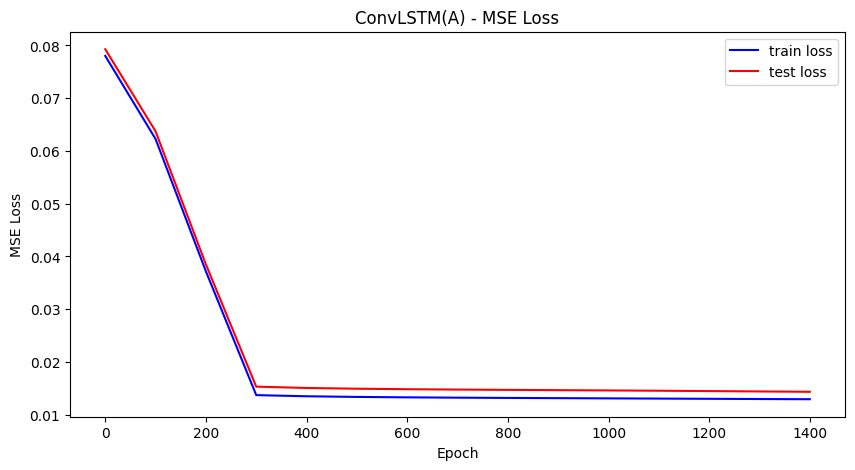

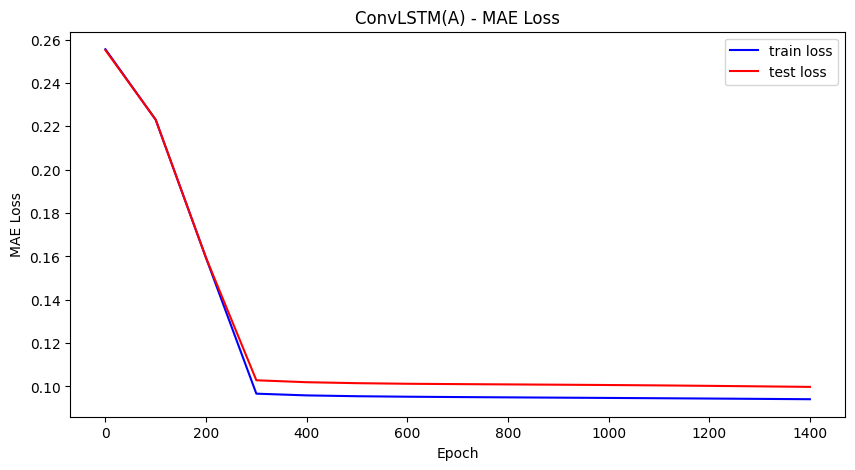

In [22]:
training_loop(1500, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test)

## predictions 

In [23]:
def inverse_scaling(y_pred, y_true, scaler):
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    y_true = scaler.inverse_transform(y_true)
    return y_pred, y_true

In [24]:
def make_prediction(X_scaled, y_scaled, lstm_model, scaler, in_step): # pass Original Scaled Dataset as Argument
    X_scaled, y_scaled = create_seq(X_scaled, y_scaled, in_step)
    X , y = torch.tensor(X_scaled), torch.tensor(y_scaled)
    lstm_model.eval()
    y_pred = lstm_model(X.float()) # forward pass
    y_pred = y_pred.detach().numpy()
    y_true = y.numpy()
    y_pred = np.repeat(y_pred, 7, axis = 1 )
    # inverse scaling
    y_pred, y_true = inverse_scaling(y_pred, y_true, scaler)
    return y_pred, y_true


In [25]:
y_pred, y_true = make_prediction(X_scaled, y_scaled, conv_lstm , mm, 7)

In [26]:
y_pred[:10]

array([59.94451 , 59.946537, 59.945797, 59.945297, 59.942467, 59.94468 ,
       59.942417, 59.94268 , 59.942684, 59.942013], dtype=float32)

In [27]:
y_true[:10].squeeze()

array([59.9       , 59.94      , 59.9       , 59.90029412, 59.90058824,
       59.90088235, 59.90117647, 59.90147059, 59.90176471, 59.90205882])

In [28]:
'''State Dict of the Trained Model'''
for param_tensor in conv_lstm.state_dict():
    print(param_tensor, "\t", conv_lstm.state_dict()[param_tensor].size())

conv.weight 	 torch.Size([64, 7, 3])
conv.bias 	 torch.Size([64])
lstm.weight_ih_l0 	 torch.Size([128, 8])
lstm.weight_hh_l0 	 torch.Size([128, 32])
lstm.bias_ih_l0 	 torch.Size([128])
lstm.bias_hh_l0 	 torch.Size([128])
fc1.weight 	 torch.Size([10, 32])
fc1.bias 	 torch.Size([10])
fc2.weight 	 torch.Size([1, 10])
fc2.bias 	 torch.Size([1])


## graphs 

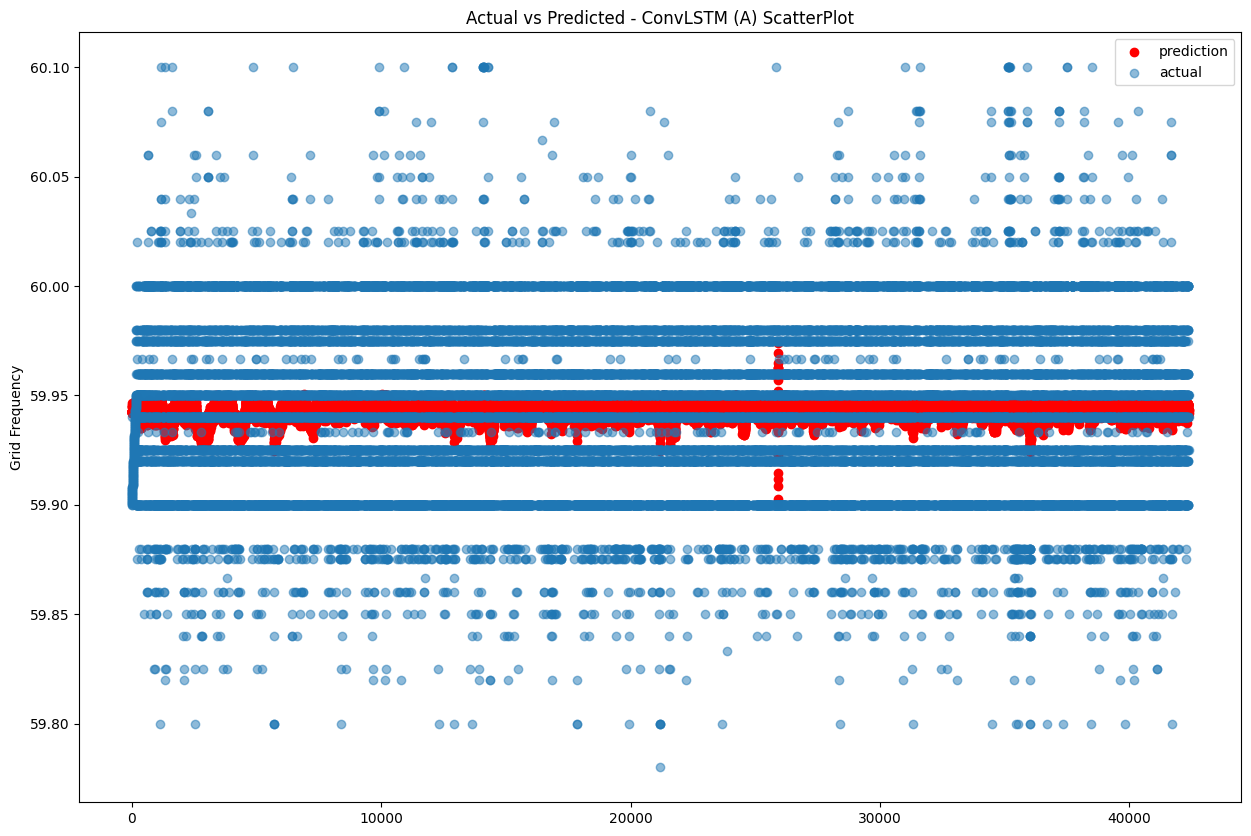

In [29]:
plt.figure(figsize = (15,10))
plt.scatter(np.arange(0,len(y_pred)),y_pred, label = 'prediction', c='r')
plt.scatter(np.arange(0,len(y_pred)),y_true.flatten(), label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (A) ScatterPlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_A - Scatter Plot.png')
plt.show()

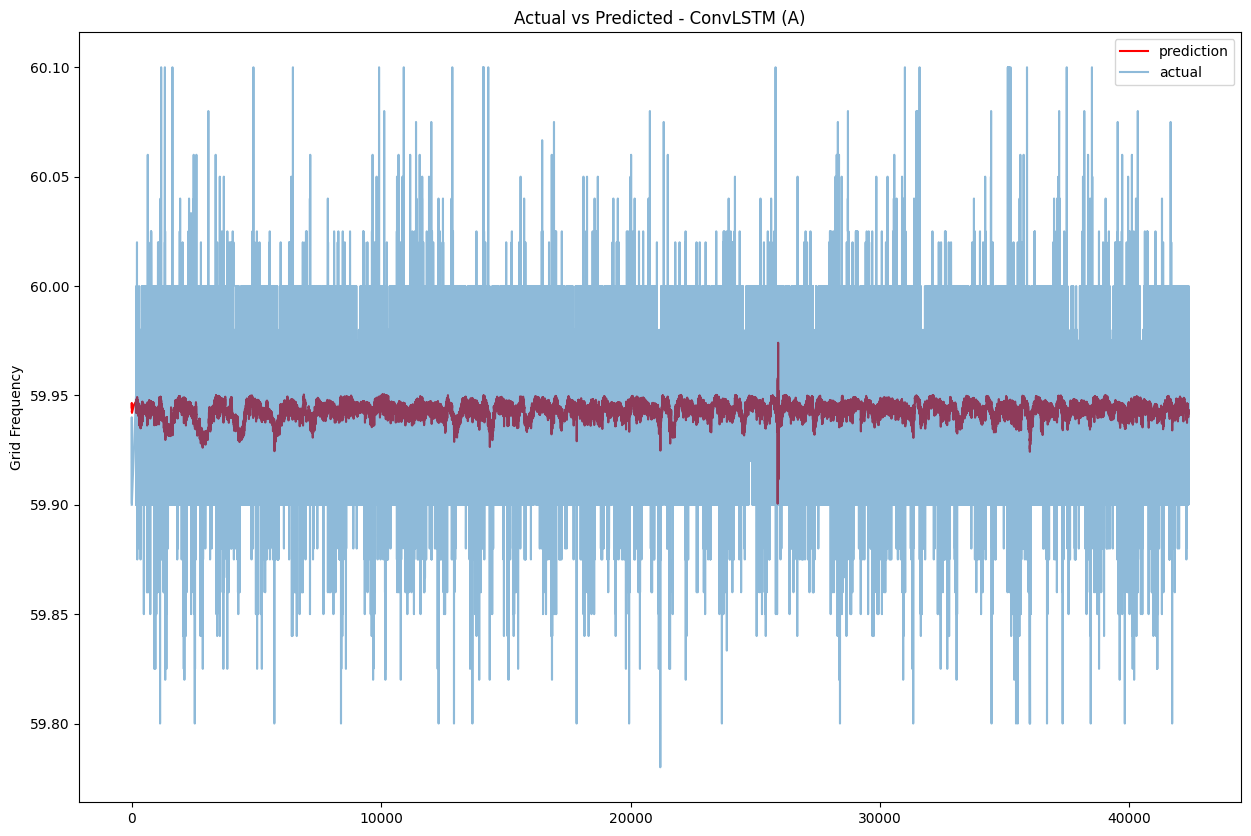

In [30]:
plt.figure(figsize = (15,10))
plt.plot(y_pred, label = 'prediction', c='r')
plt.plot(y_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (A)')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_A - Line Plot.png')
plt.show()